In [101]:
import numpy as np 
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import datetime

In [102]:
X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/churchland.npy') 
X = jnp.array(X) 
print(X.shape)

(108, 218, 61)


In [103]:
X_norm_const = jnp.maximum(jnp.max(X, axis=(0,2),  keepdims=True ), 0.1)
X_normalized = X / X_norm_const
mean_across_conditions = jnp.mean(X_normalized, axis=0, keepdims=True) 
X_normalized = X_normalized - mean_across_conditions


In [36]:
mean_across_conditions = jnp.mean(X, axis=0)                    #PETH mean across condition subtracted 
X_centered = X - mean_across_conditions

# mean_across_conditions_and_time = jnp.mean(X, axis=(0, 2))
# mean_across_conditions_and_time = mean_across_conditions_and_time[:, None]
# X_centered = X - mean_across_conditions_and_time

In [100]:
seed = 42
key = random.PRNGKey(seed)
keys = random.split(key, num=5000)


U = random.normal(keys[8], (1, 2))


Array([[0.36254656, 0.04037654]], dtype=float32)

In [106]:
def single_pair_loss(U_tilde, X, id_1, id_2):                           #U (N,d); X(K,N,T)

    Y = jnp.einsum('ji,jk->ik', U_tilde, X[id_1, :, :])                 #(d,T)
    Y_prime = jnp.einsum('ji,jk->ik', U_tilde, X[id_2, :, :])           #(d,T)

    YY = jnp.einsum('ij,kj->ik', Y, Y_prime)                            #(d,d)
    YY_product = jnp.einsum('ij,lm->im', YY, YY)                        #(d,d)

    S_pair = jnp.trace(YY)**2 - jnp.trace(YY_product)
    return S_pair

def loss(U, X, key):  
    K, N, T = X.shape
    U_tilde, _ = jnp.linalg.qr(U)

    num_pairs = 100  
    #key = random.PRNGKey(seed)
    indices = random.randint(key, shape=(num_pairs*2,), minval=0, maxval=N)
    index_pairs = indices.reshape((num_pairs, 2))

    batched_loss = vmap(single_pair_loss, in_axes=(None, None, 0, 0))(U_tilde, X, index_pairs[:, 0], index_pairs[:, 1]) #(num_pairs)

    S = (2 / (K**2) ) * jnp.sum(batched_loss)
    return -S

#grad_loss = grad(loss)

def update_U(U, X, optimizer, opt_state, i, key):
    #dL_dU = grad_loss(U, X)
    #print(key)
    dL_dU = grad(loss)(U,X,key)
    if i % 10 == 0:
        print(f'dL_dU = {jnp.mean(dL_dU)}')
    updates, opt_state_updated = optimizer.update(dL_dU, opt_state, U)
    U_updated = optax.apply_updates(U, updates)
    return U_updated, opt_state_updated

def optimize_U(X, iterations=5000, learning_rate=0.001, d=3, seed=42):
    K, N, T = X.shape
    key = random.PRNGKey(seed)
    U = random.normal(key, (N, d))

    keys = random.split(key, num=iterations)

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(U)
    
    ls_fun = []

    for i in range(iterations):
        U, opt_state = update_U(U, X, optimizer, opt_state, i, keys[i])
        ls_fun.append(loss(U, X, keys[i]))
        if i % 10 == 0:
            print(f"Iteration {i}, S: {-loss(U, X, keys[i])}")
    
    return U, ls_fun

optimized_U = optimize_U(X_normalized)                     #optimized_U (N,d)

now = datetime.datetime.now()
date_time_str = now.strftime('%d%m%Y_%H%M%S')
file_name = 'optimized_U_linear_SCA/optimized_U_' + date_time_str
np.save(file_name, optimized_U[0])

[1714774725 4123590984]
dL_dU = 0.00025108869886025786
Iteration 0, S: -0.012027901597321033
[1034117459 1345554821]
[ 699390649 1627730102]
[ 546432673 3864732262]
[1706561171  325829470]
[1687413528 2426003946]
[3725182195  411636122]
[3656368108 2003448392]
[3198133481   20953388]
[1229126460  798748945]
[1408394091  498174176]
dL_dU = 0.0002309751434950158
Iteration 10, S: -0.0004572951002046466
[773445583 926288565]
[ 475257277 3074005425]
[ 319288334 1312151087]
[ 529403772 2693369481]
[3155467435 3705415242]
[4105349245 1463490090]
[ 768203935 2802140151]
[ 662115722 3158609638]
[ 911750820 4138957482]
[3610532334  383903699]
dL_dU = 0.00026014805189333856
Iteration 20, S: 0.00395120307803154
[2025662976 2113109856]
[3553973172 3955558162]
[   9278985 4032953149]
[1299896136 3950604347]
[1176737779 3144905435]
[3506438493 1152218793]
[3486004902 3788551586]
[1693584595 2814869886]
[2364498258   70960598]
[3877099499 4108899997]
dL_dU = 0.00022649831953458488
Iteration 30, S: 0.0

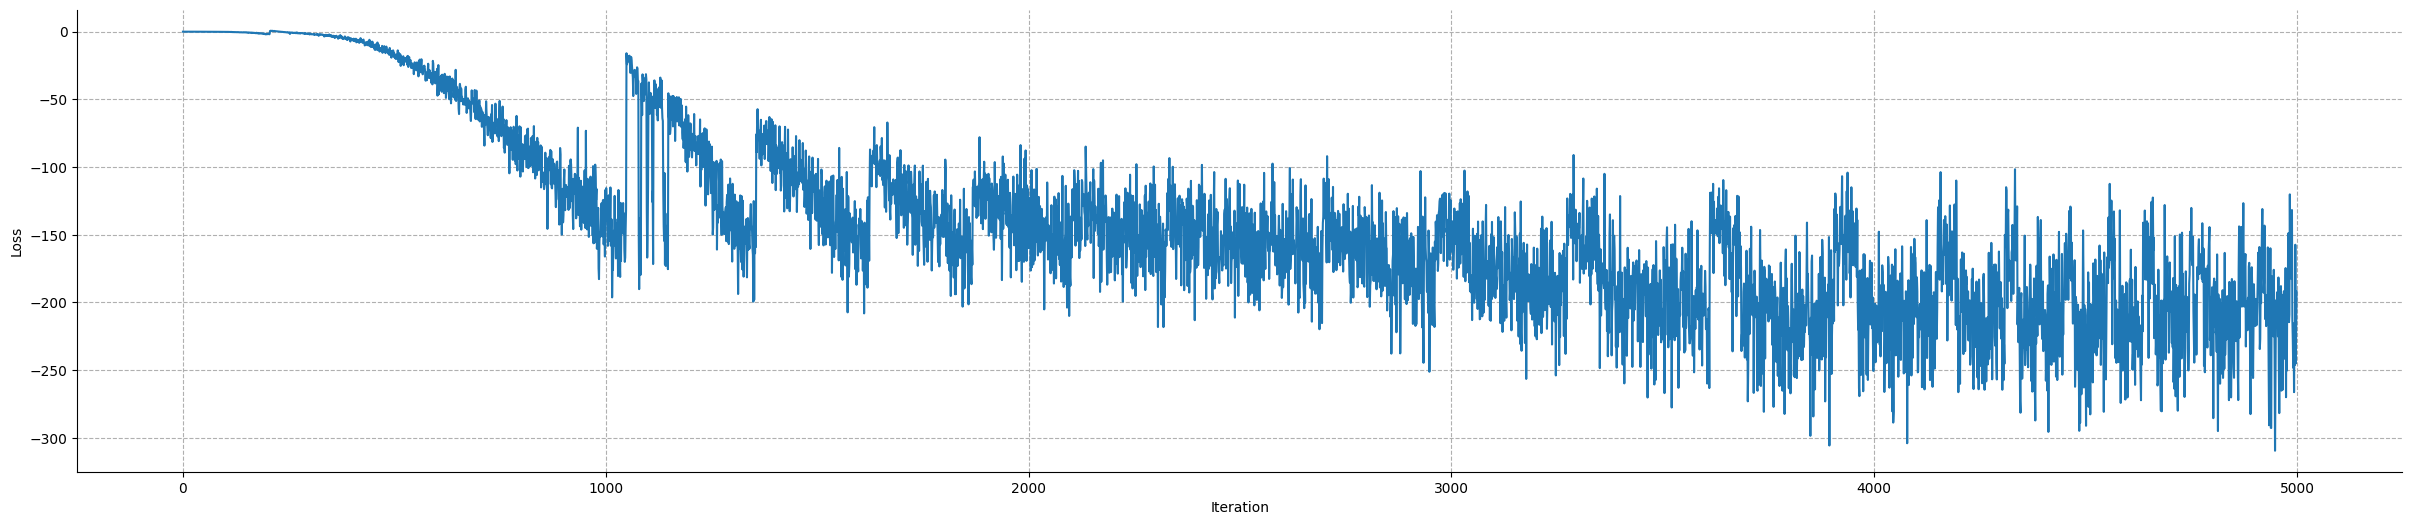

In [107]:
plt.figure(figsize=(30, 6))
plt.plot(optimized_U[1])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, which="both", ls="--") 
plt.gca().spines[['right', 'top']].set_visible(False)


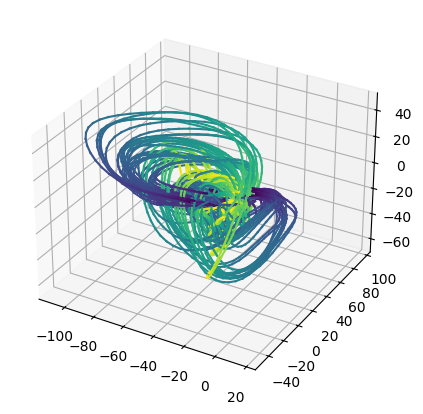

In [108]:
optimized_U_tilde, _ = jnp.linalg.qr(optimized_U[0])        
Y = jnp.einsum('ji,kjl->kil', optimized_U_tilde, X)         #(K,d,T)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('viridis')

num_time_points = Y.shape[-1]
indices_to_plot = np.arange(0,Y.shape[0],1)

for i in indices_to_plot:
    x = Y[i, 0, :]  
    y = Y[i, 1, :] 
    z = Y[i, 2, :]  
    
    for t in range(num_time_points - 1):
        ax.plot(x[t:t+2], y[t:t+2], z[t:t+2], color=cmap(t / (num_time_points - 1)))

# plt.figure()
# def make_frame(angle):
#     ax.view_init(30, angle)
#     fig.canvas.draw() 
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#     image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     return image

# angles = range(0, 360, 2) 
# frames = [make_frame(angle) for angle in angles]

# gif_path = date_time_str + "_trajectories_rotation_test.gif"
# imageio.mimsave(gif_path, frames, fps=20)

# gif_path
